## 1. Знакомство с данными. 

In [40]:

# Базовые библиотеки
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# Машинное обучение
from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings 
warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала загрузим данные:

In [16]:
df = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(df.shape))
df.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


In [3]:
# Посмотрим на типы данных столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это:

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
f"Данные представлены в промежутке с {df['InvoiceDate'].min()} по {df['InvoiceDate'].max()}"

'Данные представлены в промежутке с 2010-12-01 08:26:00 по 2011-12-09 12:50:00'

Посмотрим еще на некоторые характеристики:

In [11]:
print(f"Максимальное количество товаров: \n{df['Quantity'].max()}")
print(f"Минимальное количество товаров: \n{df['Quantity'].min()}")
print(f"Самый дешевый товар: \n{df[df['UnitPrice'] >= 0]['UnitPrice'].min()}")
print(f"Самый дорогой товар: \n{df['UnitPrice'].max()}")
print(f"Количество уникальных клиентов: \n{df['CustomerID'].nunique()}")
print(f"Количество уникальных стран: \n{df['Country'].nunique()}")

Максимальное количество товаров: 
80995
Минимальное количество товаров: 
-80995
Самый дешевый товар: 
0.0
Самый дорогой товар: 
38970.0
Количество уникальных клиентов: 
4372
Количество уникальных стран: 
38


## 2. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


Начнем с пропусков

In [12]:
# Взглянем на пропуски
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях, поэтому удалим все строки с пропусками

In [17]:
df = df.dropna()
df.shape

(406829, 8)

Следом за пропусками удалим дубликаты

In [18]:
print(f"Всего дубликатов: {df[df.duplicated()].shape[0]}")
df = df.drop_duplicates()
f"Размер таблицы после удаления: {df.shape}"

Всего дубликатов: 5225


'Размер таблицы после удаления: (401604, 8)'

Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [19]:
neg_quantity = df[(df['Quantity'] < 0)]
print(f'Количество строк с отрицательными значениями количества товара: {neg_quantity.shape[0]}')
neg_quantity.head()

Количество строк с отрицательными значениями количества товара: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


Итак, таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

  * Cимвол "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.
  * Код товара может содержать различные специальные символы: например, символ "D", судя по описанию товара, означает наличие скидки.
  * Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [13]:
indexes = []

for idx, row in enumerate(neg_quantity['InvoiceNo']):
    if row[0] != 'C':
        indexes.append(idx)
        
len(indexes)

0

Это действительно так

Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент-заказ». Сгруппируем нашу таблицу по идентификатору клиента и номеру заказа и посчитаем данное количество:

In [20]:
nb_products_per_basket = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = nb_products_per_basket.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим в таблицу бинарный признак отмены заказа и посчитаем долю отмененных заказов в таблице:

In [23]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 
                                                                                    1 if x[0]=='C' else 0)

print(f"Доля отмененных заказов: {int(round(nb_products_per_basket['order_canceled'].mean(), 2)*100)} %")

Доля отмененных заказов: 16 %


Давайте поближе взглянем на отмененные заказы:


In [16]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Приведу для примера записи принадлежащие клиенту с идентификатором 12346:

In [28]:
df[df['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Вот пример пары «заказ-отмена». Столбцы StockCode, UnitPrice, CustomerID и Quantity для двух транзакций идентичны. 

Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара. Проверим её:

In [27]:
# Скопируем таблицу, переустановим в ней индекс и заменим знак в столбце Quantity
returns = neg_quantity.copy()
returns.reset_index(inplace=True)
returns['Quantity'] = -returns['Quantity']
# Произведем соединение таблиц returns и df, затем удалим дубликаты. Таким образом, если наша гипотеза 
# верна, то в этой таблице должны остаться только записи из neg_quantity
merged = pd.merge(returns, df,
                   on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
merged.drop_duplicates(subset='index', inplace=True)
print(f'Количество несовпадений: {neg_quantity.shape[0] - merged.shape[0]}')

Количество несовпадений: 5626


Гипотеза не подтвердилась: не все заказы с отрицательным количеством товара имеют в таблице свои аналоги. Нужно дальше разбираться, почему так происходит.

Приведу еще один контр-пример. Посмотрим на клиента с идентификатором 14527:

In [35]:
df[df['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров нет. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

In [49]:
neg_quantity = neg_quantity.drop(neg_quantity[neg_quantity['StockCode'] == 'D'].index, axis=0)

print(f'Количество несовпадений: {neg_quantity.shape[0] - merged.shape[0]}')

Количество несовпадений: 5549


Эта гипотеза тоже не подтвердилась. Даже исключив товары со скидками, мы не можем найти аналогов для некоторых отменённых заказов.

Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [37]:
df[(df['CustomerID'] == '15311') & (df['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Применим функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.

In [38]:
def get_quantity_canceled(df):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(df.shape[0]), index=df.index)    
    neg_quantity = df[(df['Quantity'] < 0)].copy()
    for index, col in neg_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = df[(df['CustomerID'] == col['CustomerID']) &
                    (df['StockCode']  == col['StockCode']) & 
                    (df['InvoiceDate'] < col['InvoiceDate']) & 
                    (df['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

df['quantity_canceled'] = get_quantity_canceled(df)

Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся, поэтому можем их удалить.

In [43]:
df = df[df['Quantity'] >= 0]
df.shape

(392732, 9)

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Проверим, бывают ли другие специальные коды.

In [ ]:
# Создаем регулярное выражение, по которому будем искать специальные коды
mask = df['StockCode'].str.contains(pat=r'^[a-zA-Z]+[0-9]*', regex=True)
df[mask]['StockCode'].unique()

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны, удалим их.

In [ ]:
df = df.drop(df[mask].index, axis=0)
df.shape

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. Посмотрим сколько таких транзакций:

In [61]:
df[df['UnitPrice'] == 0.0].shape[0]

33

Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться.

In [63]:
df = df.drop(df[df['UnitPrice'] == 0.0].index, axis=0)
df.shape

(391150, 9)

## 3. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Для начала выясним, в каких странах живут клиенты. Построим график, отражающий это:

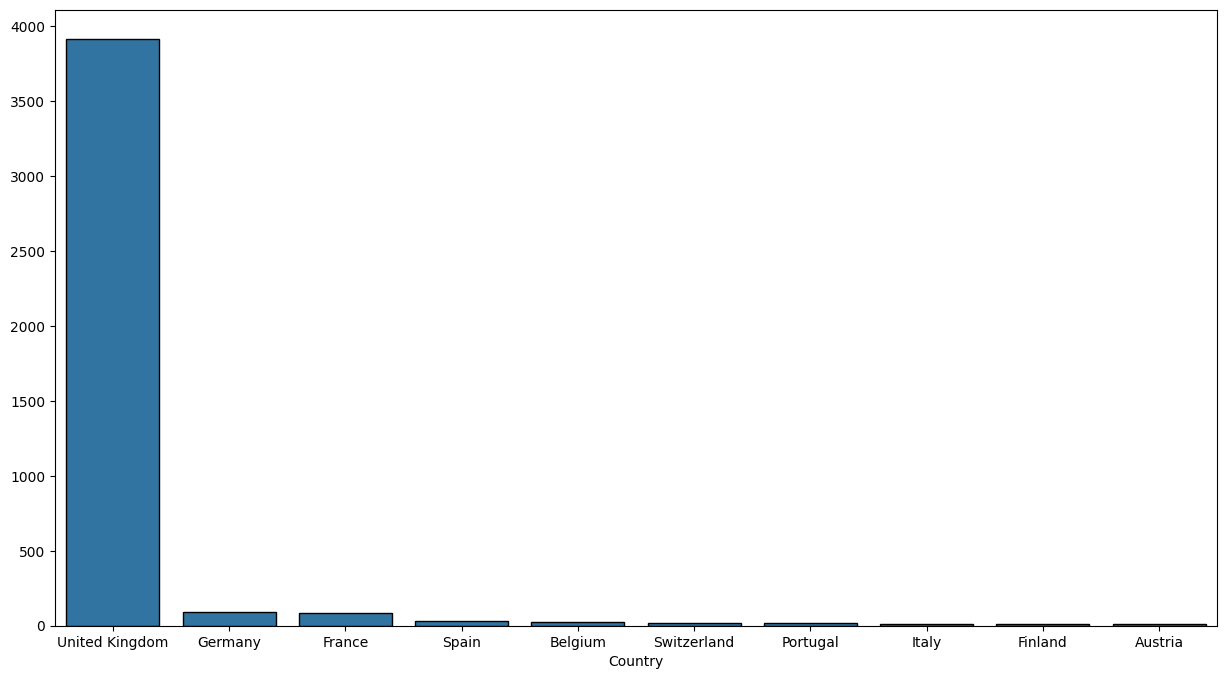

In [11]:
grouped = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head(10)
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=grouped.index, y=grouped.values);

В подавляющем большинстве это жители Великобритании

Выделим топ стран по количеству поступающих заказов:

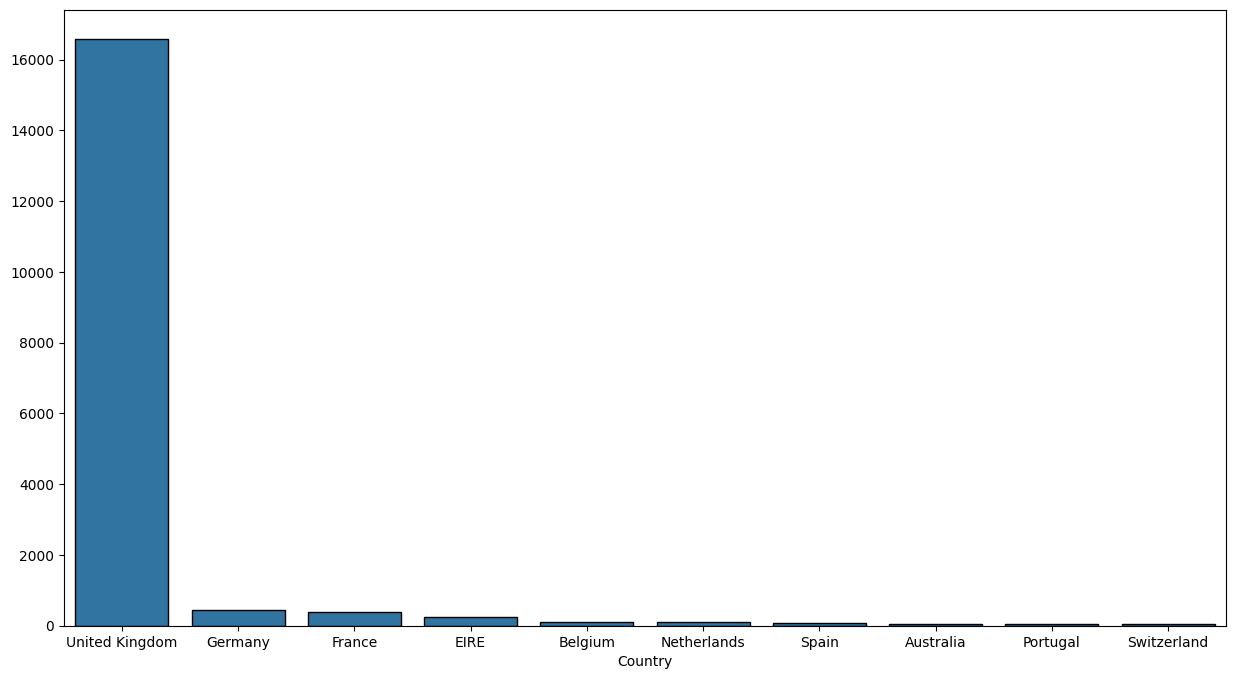

In [12]:
grouped = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).head(10)
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=grouped.index, y=grouped.values);

И здесь преимущественно из Великобритании

Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
**общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Выделим топ стран, клиенты из которых приносят компании больше всего выручки:

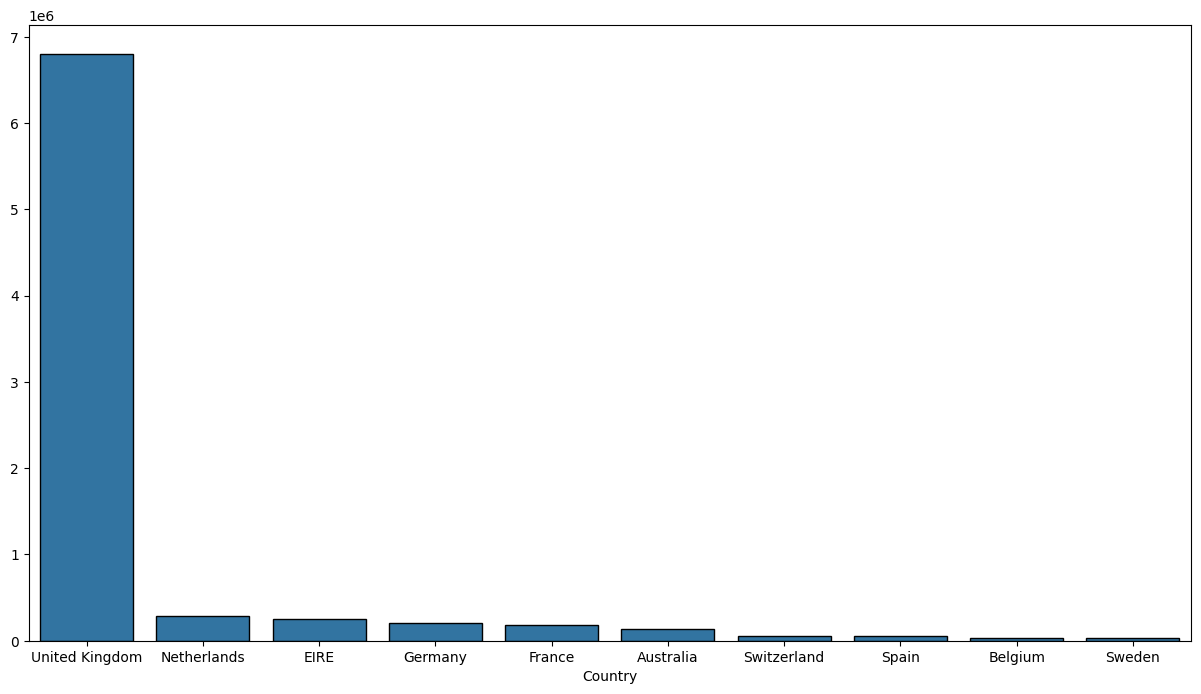

In [13]:
# Создаем столбец
df['TotalPrice'] = (df['Quantity'] - df['quantity_canceled']) * df['UnitPrice']
# Группируем
grouped = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
# Строим график
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=grouped.index, y=grouped.values);

Теперь займёмся временными характеристиками.
Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам

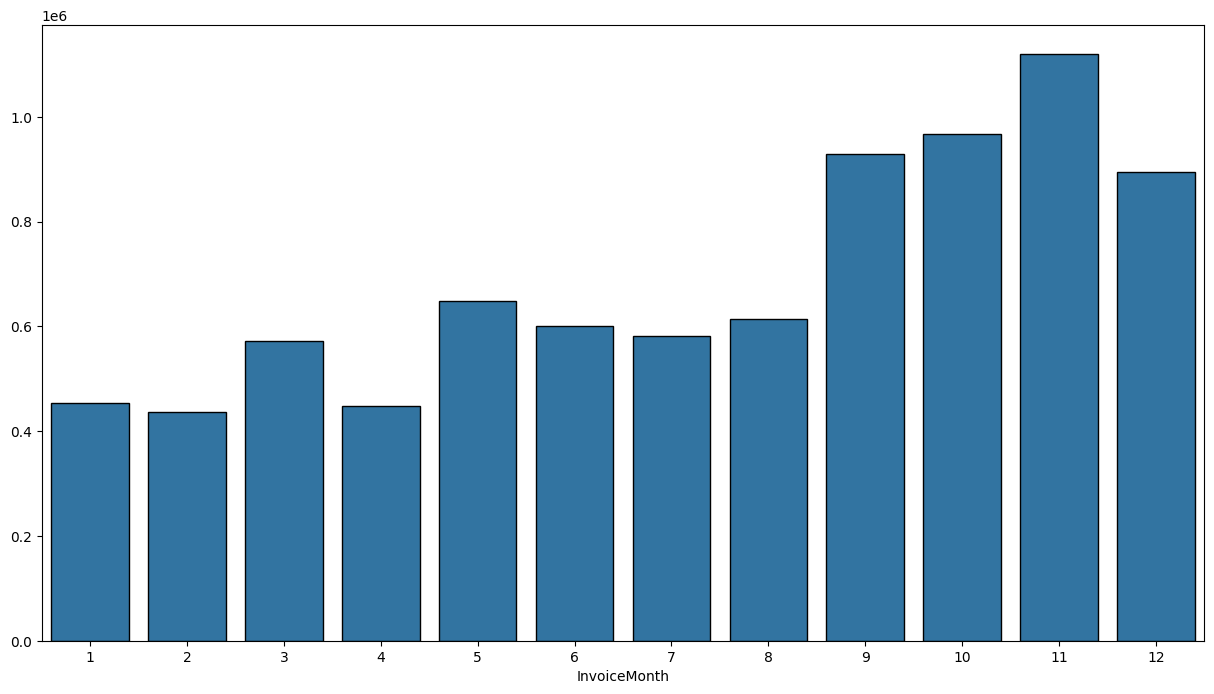

In [14]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDay_of_week'] = df['InvoiceDate'].dt.day_of_week
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

grouped = df.groupby('InvoiceMonth')['TotalPrice'].sum().sort_values(ascending=False)
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=grouped.index, y=grouped.values);

Самый прибыльный месяц - ноябрь. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

Построим визуализацию количества заказов для каждого дня недели:

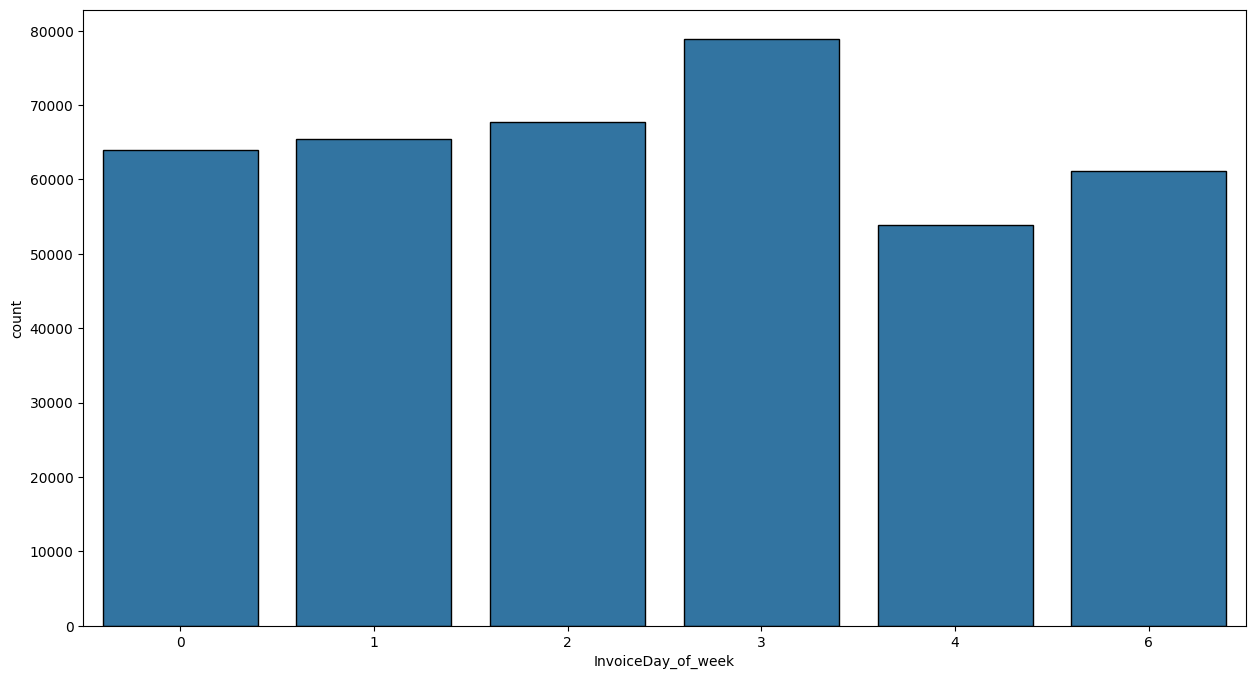

In [15]:
fig = plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='InvoiceDay_of_week');

Cогласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются.

Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток.

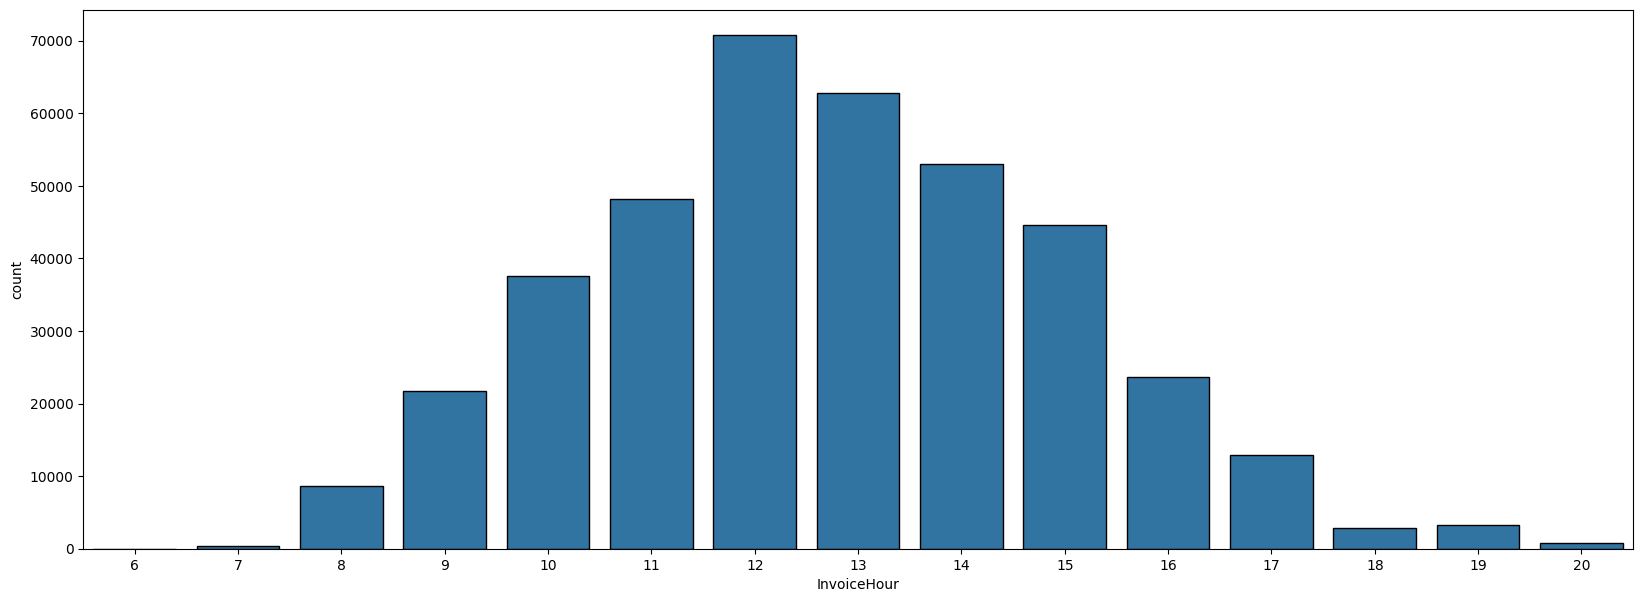

In [16]:
fig = plt.figure(figsize=(20, 7))
sns.countplot(data=df, x='InvoiceHour');

## 4. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни. В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года.
* Frequency рассчитывается как общее количество уникальных заказов, которые совершил каждый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую каждый клиент потратил на наши товары с учетом возвратов.

In [17]:
last_invoice = pd.to_datetime(df.groupby('CustomerID')['InvoiceDate'].max()) # крайний заказ
recency = (pd.to_datetime('2011-12-10 00:00:00') - last_invoice).dt.days # насколько давно сделан крайний заказ
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique() # количество заказов
monetary = df.groupby('CustomerID')['TotalPrice'].sum() # общая сумма заказов

rfm_table = pd.DataFrame({'Recency' : recency,
                          'Frequency' : frequency,
                          'Monetary'  : monetary
                          })
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


Взглянем на описательные характеристики данной таблицы

In [18]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4334.000000,4334.000000,4334.000000
mean,92.226581,4.245962,1906.689661
std,100.175327,7.634989,8304.237509
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,298.257500
50%,50.000000,2.000000,651.395000
75%,142.000000,5.000000,1606.405000
max,373.000000,206.000000,278742.020000


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

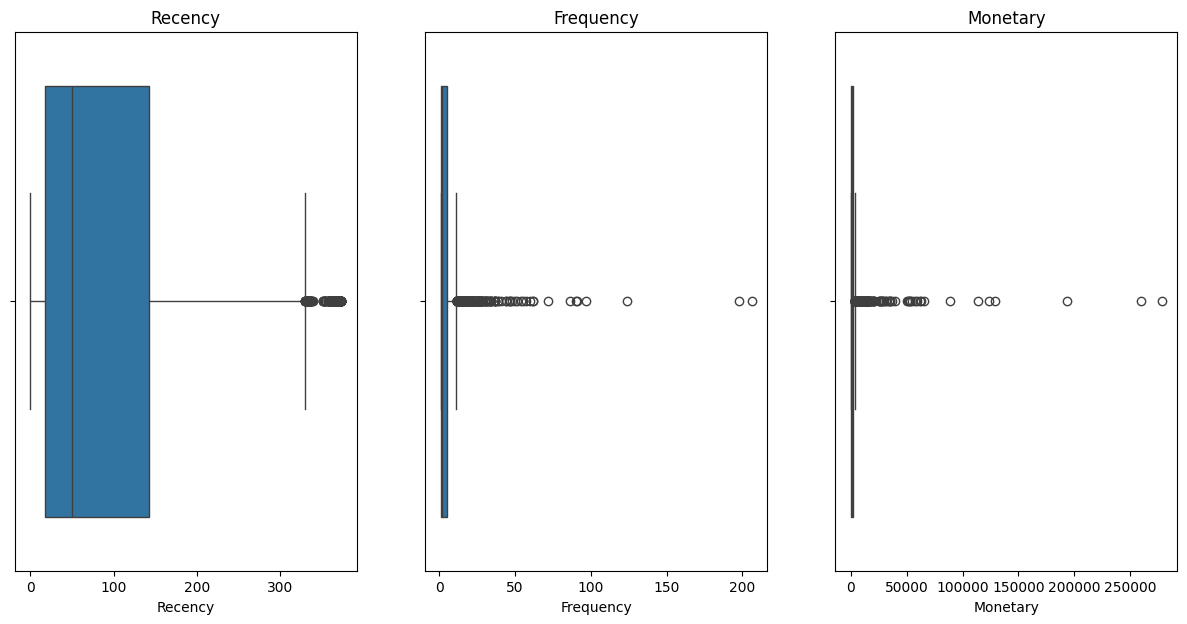

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

for i, feature in enumerate(rfm_table.columns):
    sns.boxplot(rfm_table[feature], orient='h', ax=axes[i]).set(title=feature)

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Данные выбросы могут отрицательно сказаться на результатах работы методов кластеризации, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [20]:
frec_limit = rfm_table['Frequency'].quantile(0.95)
monet_limit = rfm_table['Monetary'].quantile(0.95)

rfm_table = rfm_table[(rfm_table['Frequency'] <= frec_limit) & (rfm_table['Monetary'] <= monet_limit)]
rfm_table.shape

(4044, 3)

Посмотрим на диаграммы после удаления выбросов:

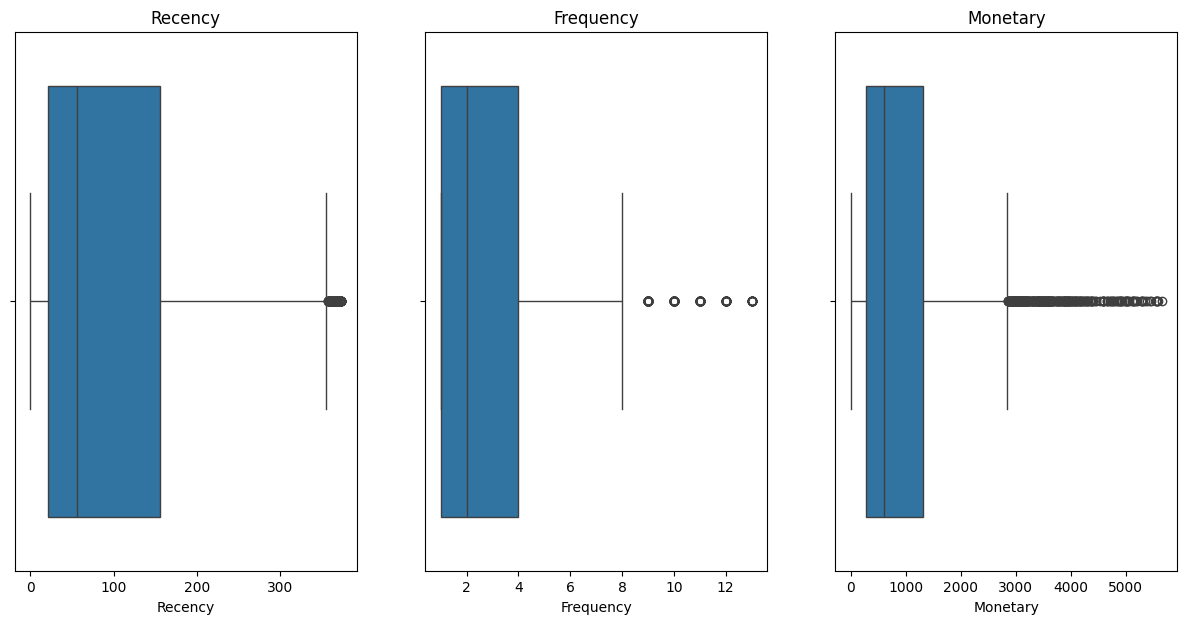

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

for i, feature in enumerate(rfm_table.columns):
    sns.boxplot(rfm_table[feature], orient='h', ax=axes[i]).set(title=feature)

Мы можем оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:

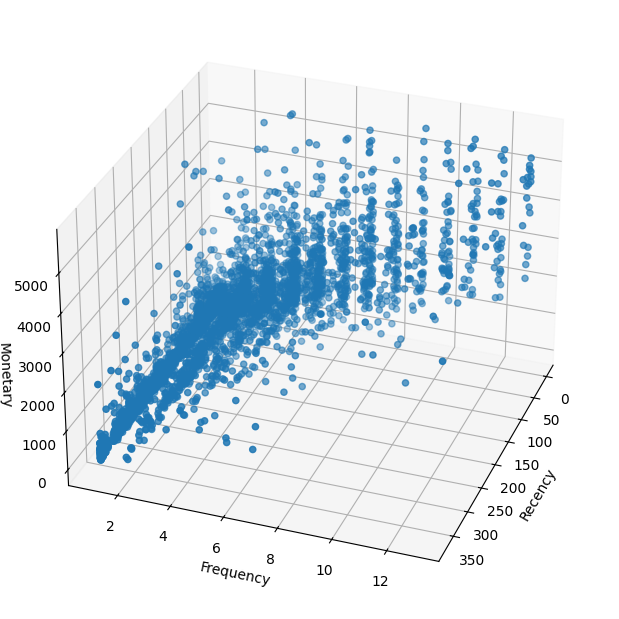

In [22]:
# Создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# Добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# Визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table['Recency'].to_list(), 
    rfm_table['Frequency'].to_list(),
    rfm_table['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline, в котором будут следующие шаги:

* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

In [23]:
pipeline = Pipeline([('scaler', preprocessing.StandardScaler()), ('pca', PCA(n_components=2))])
X = pipeline.fit_transform(rfm_table)
rfm_table_pca = pd.DataFrame(X, columns=['axis-1', 'axis-2'], index=rfm_table.index)

Визуализировав пространство главных компонент после декомпозиции:

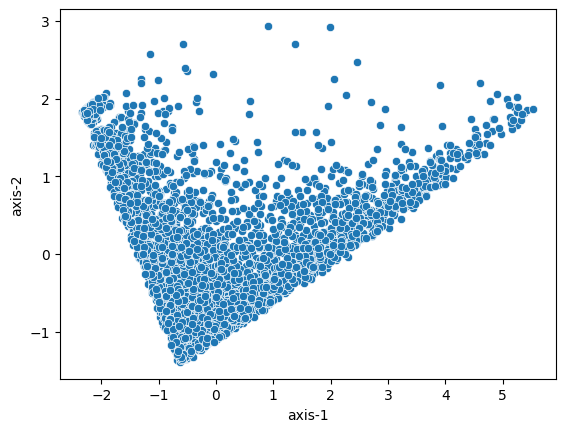

In [24]:
sns.scatterplot(data=rfm_table_pca, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

Воспользуемся методом k-means. 

Подберем с помощью цикла оптимальное количество кластеров используя коэффициент силуэта. Возьмем значения от 2 до 10 включительно.

In [25]:
silhouette = {'cluster':[], 'value':[]}

for cluster in range(2, 11):
    km = KMeans(n_clusters=cluster)
    km.fit(rfm_table_pca)
    silhouette['cluster'].append(cluster)
    silhouette['value'].append(metrics.silhouette_score(X, km.labels_))
    
silhouette = pd.DataFrame(silhouette)
silhouette.sort_values(by='value', ascending=False)

,cluster,value
1,3,0.524173
0,2,0.500194
2,4,0.497553
3,5,0.454666
4,6,0.447953
6,8,0.429373
5,7,0.419641
7,9,0.407161
8,10,0.397528


Оптимальным будет выбор 3 кластеров.

Обучим модель с 3 кластерами и добавим к нашей таблице столбец с предсказаниями.

In [26]:
km = KMeans(n_clusters=3)
rfm_table_pca['labels'] = km.fit_predict(rfm_table_pca)
rfm_table_pca['labels'].value_counts()

labels
2    2266
0    1001
1     777
Name: count, dtype: int64

Визуализируем результаты кластеризации:

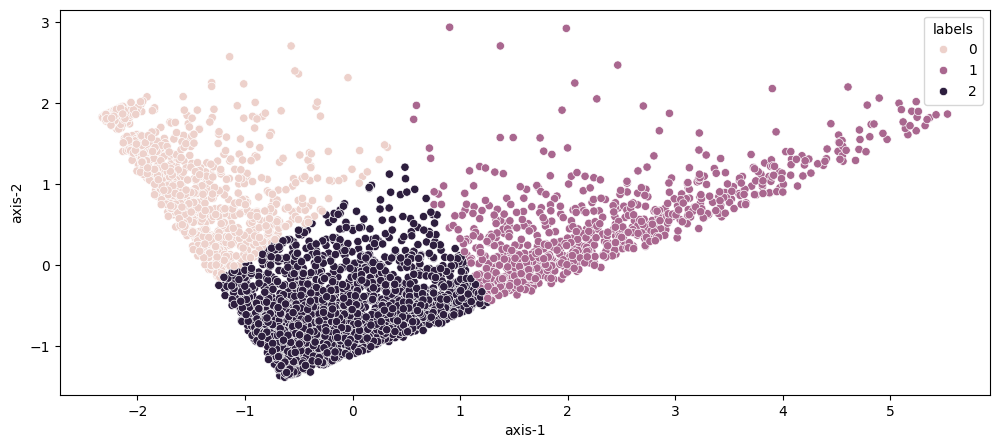

In [27]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_pca, 
    x='axis-1', 
    y='axis-2', 
    hue='labels',
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

Добавим столбец с кластерами к RFM-таблице, затем сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [28]:
rfm_table['labels'] = rfm_table_pca['labels']

grouped = rfm_table.groupby('labels').mean()
grouped

,Recency,Frequency,Monetary
labels,,,
0,253.283716,1.405594,386.598472
1,31.924067,7.065637,2656.277439
2,51.142542,2.327891,659.791037


Имея сгруппированную таблицу мы можем построить полярную диаграмму.
Для этого используем функцию plot_cluster_profile, написанную ниже.

In [29]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show('png')

Визуализируем профили кластеров в виде полярной диаграммы:

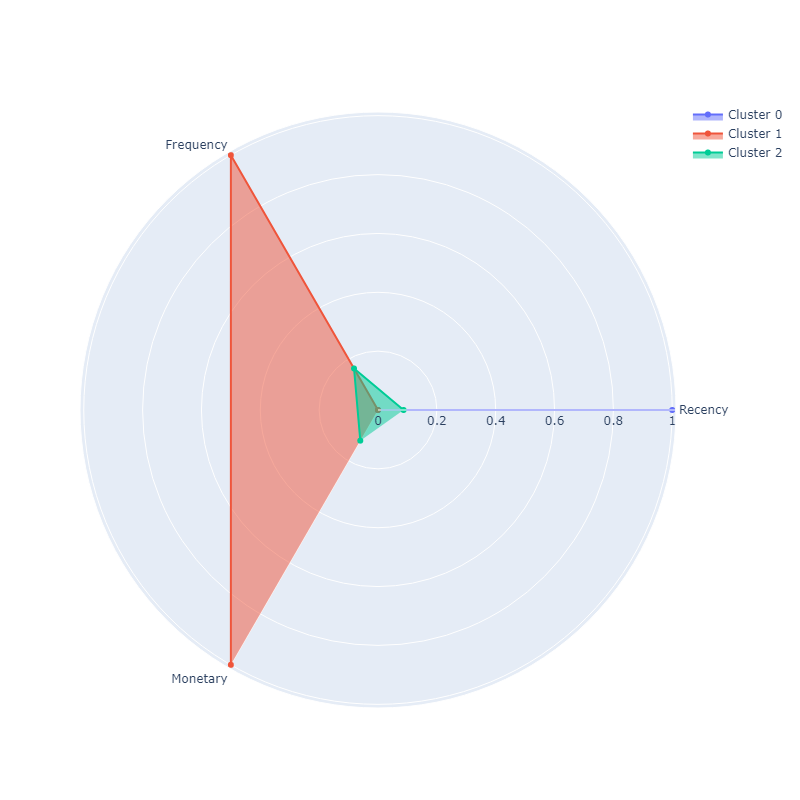

In [30]:
plot_cluster_profile(grouped, 3)

Описание кластеров:
* Кластер 0 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

* Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».


### 5. RFM-сегментация клиентов: часть 2

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

Попробуем использовать нелинейную трансформацию, например нелинейный алгоритм снижения размерности t-SNE.

Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу в двухмерное представление. Также заранее позаботимся о масштабировании признаков. Для удобства обернем эти шаги в Pipeline

In [32]:
pipeline = Pipeline([('scaler', preprocessing.StandardScaler()), 
                     ('tsne', TSNE(n_components=2, perplexity=50))]
                    )
X = pipeline.fit_transform(rfm_table.drop('labels', axis=1))
rfm_table_tsne = pd.DataFrame(X, columns=['axis-1', 'axis-2'], index=rfm_table.index)

Визуализируем пространство после декомпозиции с помощью t-SNE:

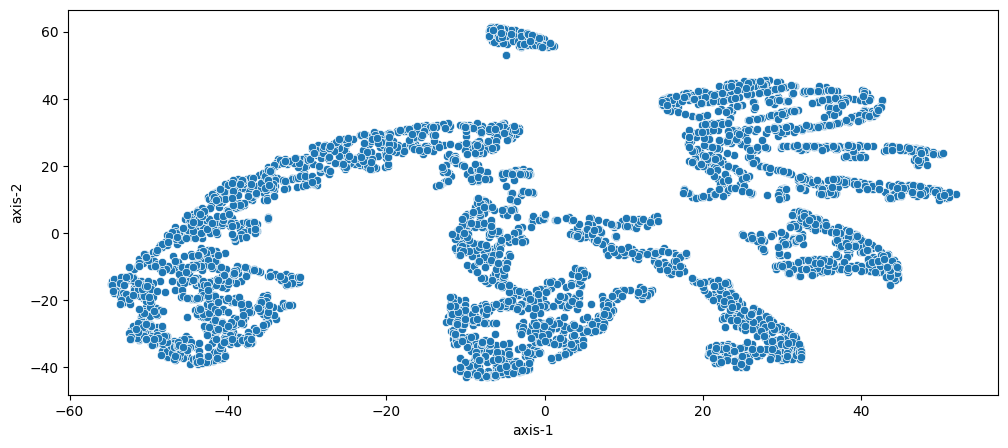

In [34]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_tsne, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.


Теперь воспользуемся методом k-means для разделения пространства на кластеры. 
Подберем оптимальное количество кластеров в цикле с помощью коэффициента силуэта.

In [35]:
silhouette = {'cluster':[], 'value':[]}

for cluster in range(3, 9):
    km = KMeans(n_clusters=cluster, random_state=42)
    km.fit(rfm_table_tsne)
    silhouette['cluster'].append(cluster)
    silhouette['value'].append(metrics.silhouette_score(X, km.labels_))
    
silhouette = pd.DataFrame(silhouette)
silhouette.sort_values(by='value', ascending=False)

,cluster,value
4,7,0.484495
5,8,0.481757
1,4,0.479317
3,6,0.479196
2,5,0.478246
0,3,0.433978


Как видим, оптимальным считается выбор 7 кластеров. Теперь обучим модель с 7 кластерами и сделаем предсказание:

In [36]:
km = KMeans(n_clusters=7)
rfm_table_tsne['labels'] = km.fit_predict(X)
rfm_table_tsne['labels'].value_counts()

labels
3    812
5    688
2    656
1    539
0    496
6    453
4    400
Name: count, dtype: int64

Визуализируем результаты кластеризации:

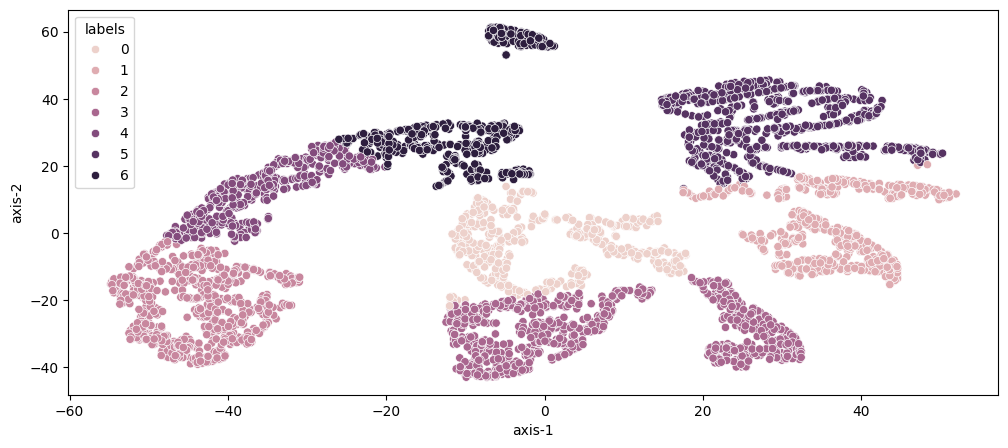

In [37]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_tsne, x='axis-1', y='axis-2', hue='labels');

Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. Вновь снруппируем таблицу уже по новым кластерам:

In [38]:
rfm_table['labels'] = rfm_table_tsne['labels']
grouped = rfm_table.groupby('labels').mean()
grouped

,Recency,Frequency,Monetary
labels,,,
0,163.987903,2.514113,696.785948
1,44.743970,4.324675,1294.389184
2,46.329268,1.000000,321.538796
3,32.626847,2.364532,724.942759
4,180.515000,1.000000,272.351525
5,27.239826,7.444767,2674.837616
6,311.134658,1.094923,339.747616


Визуализируем профили кластеров в виде полярной диаграммы:

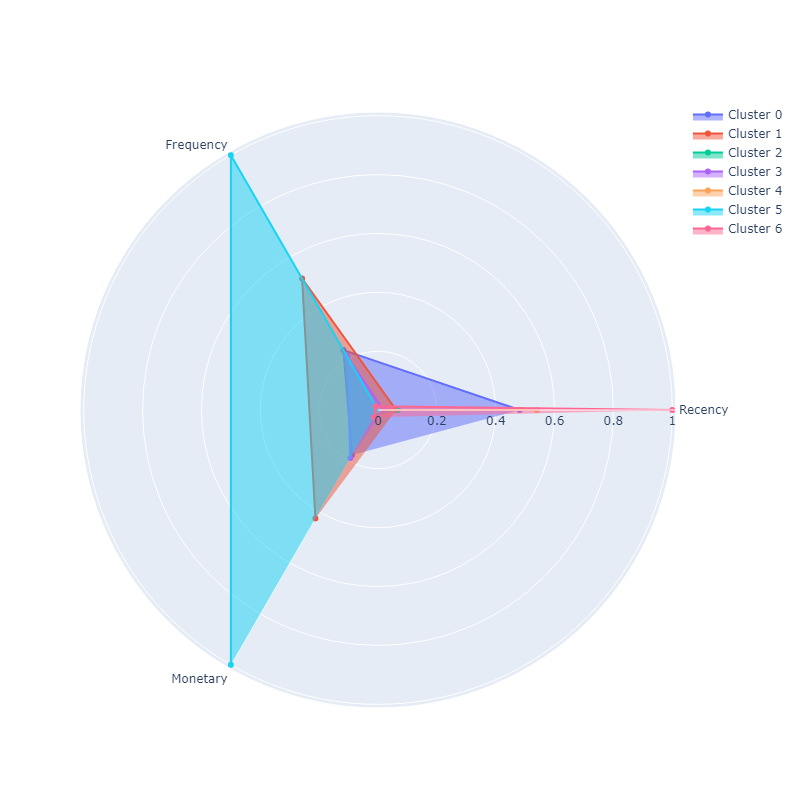

In [39]:
plot_cluster_profile(grouped, 7)

## 6. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Давайте сведём задачу кластеризации к задаче классификации. У нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20

In [41]:
X = rfm_table.drop('labels', axis=1)
y = rfm_table['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.shape

(809, 3)

Дальше нам осталось только построить модель, которая будет предсказывать кластер. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели в данной задаче нам мало чем помогут. 
Поэтому сразу возьмём ансамблевые алгоритмы, основанные на решающих деревьях. 

Начнём со случайного леса. С помощью GridSearchCV подберем наилучшие гиперпараметры и сделаем предсказание. В качестве метрики возьмем Accuracy.

In [98]:
rf = RandomForestClassifier()

param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy'
) 

grid_search.fit(X_train, y_train) 
best = grid_search.best_params_

rf = RandomForestClassifier(n_estimators=best['n_estimators'],
                            criterion=best['criterion'],
                            max_depth=best['max_depth'],
                            random_state=42
                            )

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(best)
print(f'Accuracy: {np.round(metrics.accuracy_score(y_test, y_pred), 3)}')

{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}
Accuracy: 0.985


Значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом:

In [99]:
gb = GradientBoostingClassifier()

param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

grid_search = GridSearchCV(
    estimator=gb, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy'
) 

grid_search.fit(X_train, y_train) 
best = grid_search.best_params_

gb = GradientBoostingClassifier(n_estimators=best['n_estimators'],
                                learning_rate=best['learning_rate'],
                                max_depth=best['max_depth'],
                                random_state=42
                                )

gb.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(best)
print(f'Accuracy: {np.round(metrics.accuracy_score(y_test, y_pred), 3)}')

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Accuracy: 0.985


Результат идентичен случайному лесу.

Резюмируем: мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.